In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import sys
sys.path.append('..')

In [2]:
test_indices = np.load('model_outputs/terra_test_indices.pkl', allow_pickle=True)
test_indices

array([87426,  9696, 24683, ..., 42613, 43567, 68268])

In [3]:
terra_modis_estimate = pd.read_pickle(f"data/LAND_terra_transformed_modl_targets.pkl")
terra_modis_estimate.describe()

,mTau470,mTau550,mTau660
count,1.065690e+05,1.065690e+05,1.065690e+05
mean,1.876146e-07,8.948667e-07,-2.148539e-07
std,1.000021e+00,9.999996e-01,1.000014e+00
min,-4.276146e+00,-3.898967e+00,-4.291711e+00
25%,-6.176519e-01,-6.204501e-01,-6.394090e-01
50%,-8.440448e-03,-1.028230e-03,-1.063495e-03
75%,6.146229e-01,6.253320e-01,6.357747e-01
max,4.922516e+00,4.798921e+00,4.652652e+00


In [4]:
terra_y_test = pd.read_pickle('model_outputs/terra_y_test.pkl')
terra_y_test.describe()

,aTau470,aTau550,aTau660
count,10657.000000,10657.000000,10657.000000
mean,0.004031,0.003931,0.004287
std,0.999037,0.998683,0.998120
min,-4.318263,-4.158985,-3.403075
25%,-0.667538,-0.647086,-0.682042
50%,-0.015210,-0.014267,-0.000374
75%,0.682665,0.664688,0.692916
max,3.865698,3.923462,3.479456


In [5]:
terra_mlp_out = pd.read_pickle('model_outputs/terra_mlp_out.pkl')
terra_mlp_out.describe()

,aTau470,aTau550,aTau660
count,10657.000000,10657.000000,10657.000000
mean,0.038471,0.037008,0.034179
std,0.911879,0.910071,0.902021
min,-3.729558,-3.660339,-3.341639
25%,-0.601006,-0.601222,-0.600453
50%,-0.043517,-0.051571,-0.059362
75%,0.632368,0.625975,0.618385
max,4.005246,4.034755,3.996721


In [6]:
terra_edl_out_np = np.load('model_outputs/terra_edl_out_edl_param=0.15.npy')
terra_mu, terra_v, terra_alpha, terra_beta = tf.split(terra_edl_out_np, [terra_mlp_out.shape[1] for i in range(4)], axis=-1)
terra_var = np.sqrt(terra_beta / (terra_v * (terra_alpha - 1)))
terra_edl_out = pd.DataFrame(terra_mu.numpy(), columns=terra_mlp_out.columns)

2022-03-13 00:38:50.757621: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
from kde import calc_kde2d
from aod_models import plot_kde2d, plot_linregress, plot_linregress_diff

Starting the 2D kernel density estimation with 10657 data points...
Evaluating 2D kernel on grid with (Nx,Ny)=(256,256) ...
X, Y, P shapes:  (256, 256) (256, 256) (256, 256)


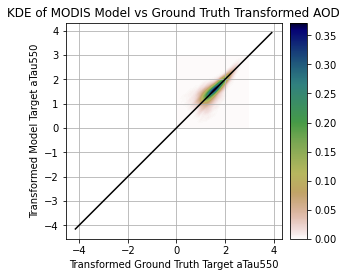

In [8]:
transformed_y_test = terra_y_test.aTau550
transformed_modis_y_test_aod = terra_modis_estimate.iloc[test_indices].mTau550
y_test_bins, out_bins_modis, P_modis = calc_kde2d(transformed_y_test, transformed_modis_y_test_aod)
plot_kde2d(y_test_bins, out_bins_modis, P_modis, x_bounds=[0,3], y_bounds=[0,3], Title='KDE of MODIS Model vs Ground Truth Transformed AOD', xLabel='Transformed Ground Truth Target aTau550', yLabel='Transformed Model Target aTau550')

Starting the 2D kernel density estimation with 10657 data points...
Evaluating 2D kernel on grid with (Nx,Ny)=(256,256) ...
X, Y, P shapes:  (256, 256) (256, 256) (256, 256)


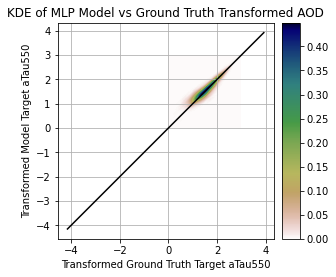

In [9]:
transformed_y_test = terra_y_test.aTau550
transformed_out_df = terra_mlp_out.aTau550
y_test_bins, out_bins, P = calc_kde2d(transformed_y_test, transformed_out_df)
plot_kde2d(y_test_bins, out_bins, P, Title='KDE of MLP Model vs Ground Truth Transformed AOD', xLabel='Transformed Ground Truth Target aTau550', yLabel='Transformed Model Target aTau550')

Starting the 2D kernel density estimation with 10657 data points...
Evaluating 2D kernel on grid with (Nx,Ny)=(256,256) ...
X, Y, P shapes:  (256, 256) (256, 256) (256, 256)


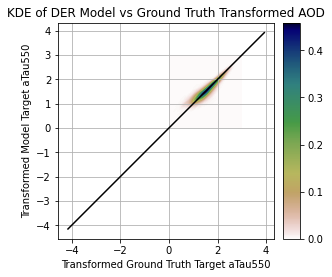

In [10]:
transformed_y_test = terra_y_test.aTau550
transformed_out_edl_df = terra_edl_out.aTau550
y_test_bins, out_edl_bins, P_edl = calc_kde2d(transformed_y_test, transformed_out_edl_df)
plot_kde2d(y_test_bins, out_edl_bins, P_edl, Title='KDE of DER Model vs Ground Truth Transformed AOD', xLabel='Transformed Ground Truth Target aTau550', yLabel='Transformed Model Target aTau550')

0.798883277863368 -0.004819595498052245 0.7935942663736977 0.0 0.0059337748598737305
0.7935942663736977


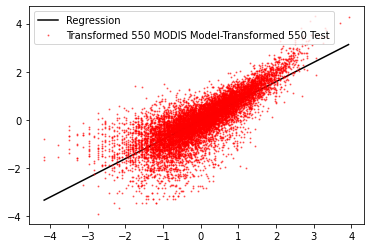

In [11]:
# MODIS lin reg
r = plot_linregress(transformed_y_test, transformed_modis_y_test_aod, np.linspace(transformed_y_test.min(), transformed_y_test.max()), 'Transformed 550 MODIS Model-Transformed 550 Test')
print(r)

0.8230531075520471 0.033773378640024235 0.903193386443752 0.0 0.0037893468305555712
0.903193386443752


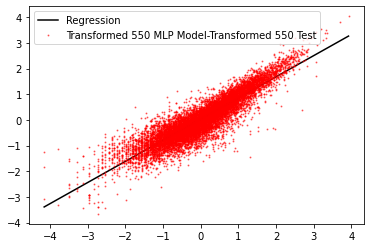

In [12]:
# MLP lin reg
r = plot_linregress(transformed_y_test, transformed_out_df, np.linspace(transformed_y_test.min(), transformed_y_test.max()), 'Transformed 550 MLP Model-Transformed 550 Test')
print(r)

0.8050915373225619 0.008984452849667007 0.9022521175655855 0.0 0.003727591747533205
0.9022521175655855


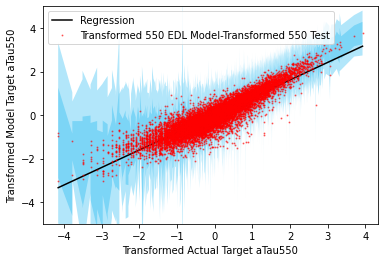

In [13]:
# EDL lin reg
n_stds = 4
std = np.minimum(np.sqrt(terra_var), 1e3)
r = plot_linregress(transformed_y_test, transformed_out_edl_df, np.linspace(transformed_y_test.min(), transformed_y_test.max()), 'Transformed 550 EDL Model-Transformed 550 Test')
indices = np.argsort(transformed_y_test)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - std[indices][:,1]), (transformed_out_edl_df[indices] + std[indices][:,1]),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - 2*std[indices][:,1]), (transformed_out_edl_df[indices] + 2*std[indices][:,1]),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.xlabel('Transformed Actual Target aTau550')
plt.ylabel('Transformed Model Target aTau550')
plt.ylim([-5,5])
print(r)

0.8050915373225619 0.008984452849667007 0.9022521175655855 0.0 0.003727591747533205
[-0.09311485  0.8567421   0.7433489  ... -1.0244586   1.2942216
  0.5500712 ]
0.9022521175655855


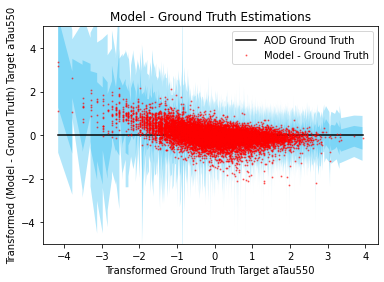

In [14]:
n_stds = 4
std = np.minimum(np.sqrt(terra_var), 1e3)
r = plot_linregress_diff(transformed_y_test.values, transformed_out_edl_df.values, np.linspace(transformed_y_test.min(), transformed_y_test.max()))
indices = np.argsort(transformed_y_test)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - std[indices][:,1] - transformed_y_test[indices].values), (transformed_out_edl_df[indices] + std[indices][:,1] - transformed_y_test[indices].values),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - 2*std[indices][:,1] - transformed_y_test[indices].values), (transformed_out_edl_df[indices] + 2*std[indices][:,1] - transformed_y_test[indices].values),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.xlabel('Transformed Ground Truth Target aTau550')
plt.ylabel('Transformed (Model - Ground Truth) Target aTau550')
plt.legend(loc='best')
plt.ylim([-5,5])
print(r)

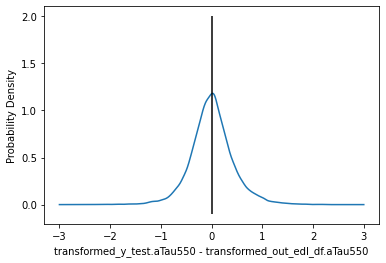

In [15]:
from sklearn.neighbors import KernelDensity
diff_transformed_aod_estimations = transformed_out_edl_df.to_numpy() - transformed_y_test.to_numpy()
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(diff_transformed_aod_estimations[:, np.newaxis])
X_plot = np.linspace(-3, 3, 1000)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens))
plt.xlabel('transformed_y_test.aTau550 - transformed_out_edl_df.aTau550')
plt.ylabel('Probability Density')
plt.vlines(0, ymin=-0.1, ymax=2, color='k')

## Aleatoric vs Epistemic Error

2369.931588453993 0.3296062166169358 0.2033013410175042 8.278210695790451e-100 110.57401585704449


0.2033013410175042

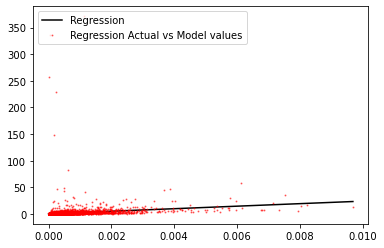

In [16]:
aleatoric_error = terra_beta / ((terra_alpha - 1))
epistemic_error = terra_beta / (terra_v * (terra_alpha - 1))
n_linregress = aleatoric_error.shape[0]
plot_linregress(aleatoric_error[:, 0], epistemic_error[:, 0], np.linspace(np.min(aleatoric_error[:, 0]), np.max(aleatoric_error[:, 0]), n_linregress))


In [17]:
aleatoric_error[:, 0]

<tf.Tensor: shape=(10657,), dtype=float32, numpy=
array([2.1639724e-04, 7.4707532e-05, 3.0062743e-04, ..., 3.5487779e-03,
       1.1909922e-05, 8.8558743e-05], dtype=float32)>

In [18]:
terra_alpha

<tf.Tensor: shape=(10657, 3), dtype=float32, numpy=
array([[1.1990206, 1.1961668, 1.1679833],
       [1.5079674, 1.525705 , 1.5350078],
       [1.4125947, 1.4317269, 1.4707273],
       ...,
       [1.0836121, 1.0882356, 1.0585003],
       [1.5278662, 1.5130521, 1.58625  ],
       [1.2648069, 1.2637286, 1.264299 ]], dtype=float32)>

0.8050915373225619 0.008984452849667007 0.9022521175655855 0.0 0.003727591747533205
[-0.09311485  0.8567421   0.7433489  ... -1.0244586   1.2942216
  0.5500712 ]
0.9022521175655855


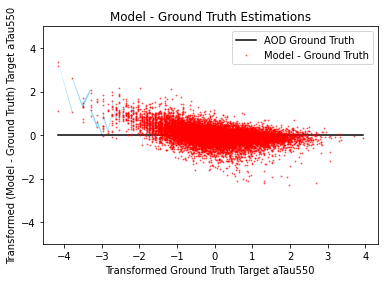

In [19]:
n_stds = 4
std = np.minimum(np.sqrt(aleatoric_error), 1e3)
r = plot_linregress_diff(transformed_y_test.values, transformed_out_edl_df.values, np.linspace(transformed_y_test.min(), transformed_y_test.max()))
indices = np.argsort(transformed_y_test)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - std[indices][:,1] - transformed_y_test[indices].values), (transformed_out_edl_df[indices] + std[indices][:,1] - transformed_y_test[indices].values),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - 2*std[indices][:,1] - transformed_y_test[indices].values), (transformed_out_edl_df[indices] + 2*std[indices][:,1] - transformed_y_test[indices].values),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.xlabel('Transformed Ground Truth Target aTau550')
plt.ylabel('Transformed (Model - Ground Truth) Target aTau550')
plt.legend(loc='best')
plt.ylim([-5,5])
print(r)